In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 原系列の表示

Text(0, 0.5, 'Passengers')

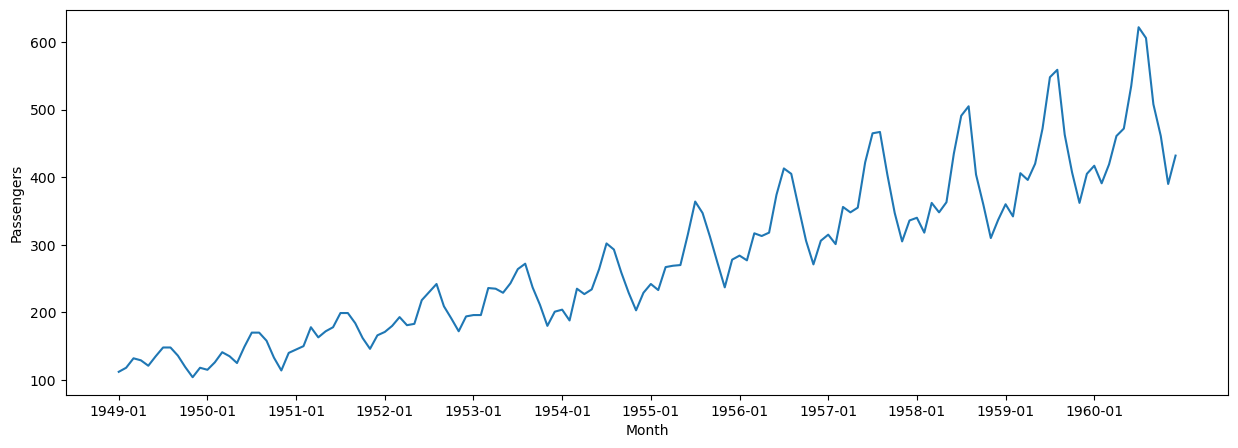

In [17]:
PATH = 'C://data//time_series_data//AirPassengers.csv'
assert(os.path.exists(PATH))
data = pd.read_csv(PATH)
plt.figure(figsize=(15, 5))

plt.plot(data["Month"], data['#Passengers'])
# plot values in 12 month intervals
plt.xticks(data["Month"][::12])
plt.xlabel('Month')
plt.ylabel('Passengers')

### 中身を見る

In [18]:
print(data.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


### 原系列の自己相関を見る

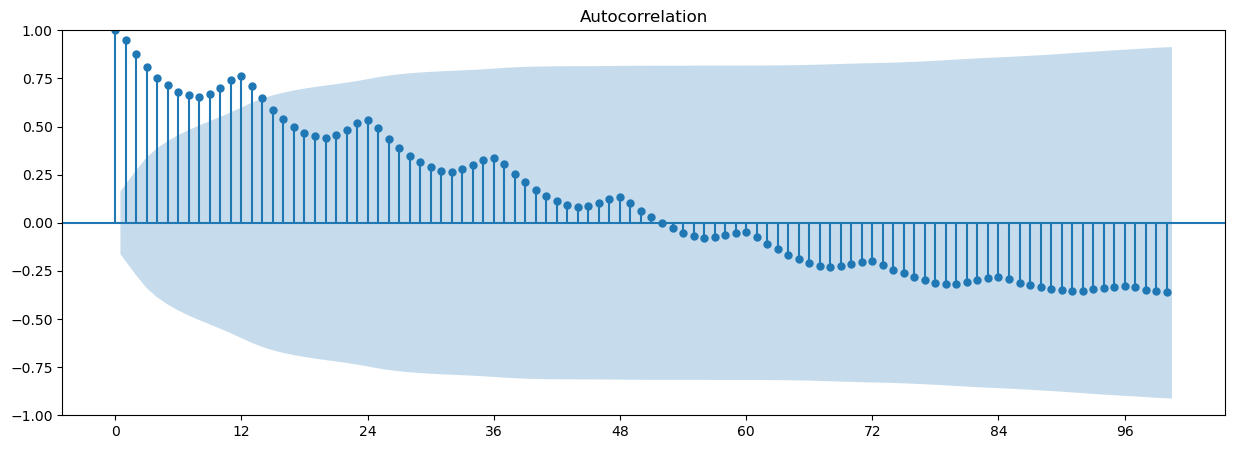

In [19]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.set_xticks(range(0, len(data), 12))
fig = sm.graphics.tsa.plot_acf(data["#Passengers"], lags=100, ax=ax1)
plt.savefig("..//images//acf.png")

周期は12のようである。

### 1階差分を取る
データを定常過程したいから。

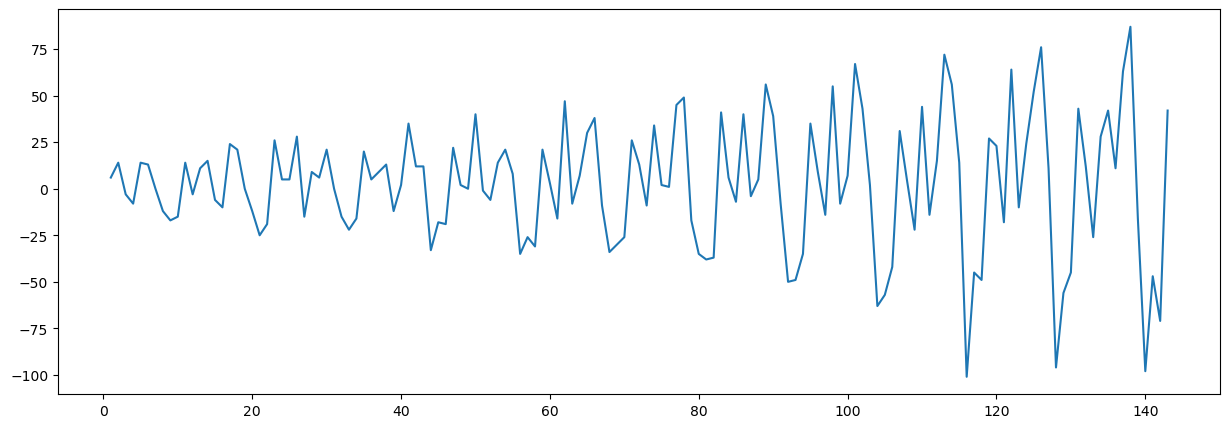

In [20]:
diff_data = data["#Passengers"].diff(periods=1).dropna()
plt.figure(figsize=(15, 5))
plt.plot(diff_data)

- トレンド（単調増加）は消滅した。
- 平均値ゼロ近傍を振動している。定常過程のようだ

### 1階差分の自己相関を見る

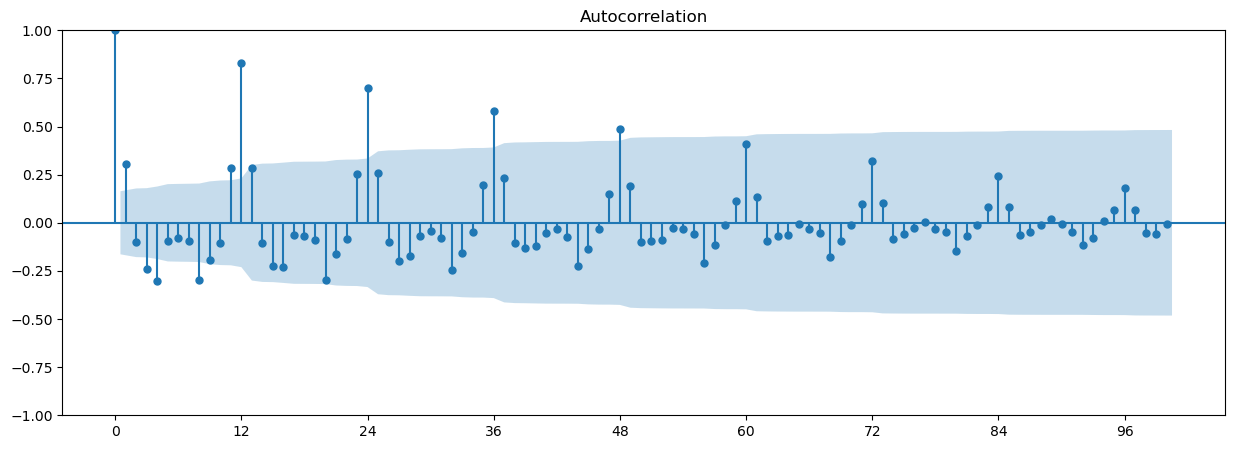

In [21]:

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.set_xticks(range(0, len(data), 12))
fig = sm.graphics.tsa.plot_acf(diff_data, lags=100, ax=ax1)
plt.savefig("..//images//acf_diff_1.png")

周期は12で良さそうだ。

### 差分回数を調べる

In [22]:
import statsmodels.api as sm

# 原系列に対して
kpss_stat, p_value, lags, crit = sm.tsa.kpss(data["#Passengers"])
print(f"kpss_stat: {kpss_stat}")
print(f"p_value: {p_value}")
print(f"lags: {lags}")
print(f"cirt: {crit}")

kpss_stat: 1.6513122354165206
p_value: 0.01
lags: 8
cirt: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [23]:
# 1階差分系列に対して
kpss_stat, p_value, lags, crit = sm.tsa.kpss(diff_data)
print(f"kpss_stat: {kpss_stat}")
print(f"p_value: {p_value}")
print(f"lags: {lags}")
print(f"cirt: {crit}")

kpss_stat: 0.023897614400183963
p_value: 0.1
lags: 7
cirt: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


- 原系列のときp_value=0.01が0.05より小さいから単位根ありである。差分を取る。
- 1階差分系列のときp_value=0.1が0.05より大きいから単位根なしである。差分を取らない。

以上から原系列は単位根過程（和分1次の過程）である。

別の関数で差分回数を判定してみる。

In [24]:
from pmdarima import arima

d = arima.ndiffs(data["#Passengers"])
print(f"d: {d}")

d: 1


1と出た。差分回数は$d=1$で良さそうだ。また、先に見たように$m=12$である。

### 訓練データとテストデータに分割する

In [25]:
from pmdarima import model_selection
df_train, df_test = model_selection.train_test_split(data, train_size=0.8)
print(f"training data size: {len(df_train)}")
print(f"test data size: {len(df_test)}")

print("training data ---")
print(df_train.head())

print("test data ---")
print(df_test.head())
# display the fisrt value of the "Month" column
print(df_test["Month"].iloc[0])

training data size: 115
test data size: 29
training data ---
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
test data ---
       Month  #Passengers
115  1958-08          505
116  1958-09          404
117  1958-10          359
118  1958-11          310
119  1958-12          337
1958-08


### 訓練データでパラメータ最適化

In [26]:
import utils
d = 1
m = 12
best_result = utils.execute_grid_search(df_train["#Passengers"], d, m)
a = best_result[0]
A = best_result[1]
print(f"> best model(p,d,q),(P,D,Q,m),AIC: {best_result}")

order(0, 1, 0), s_order(0, 0, 0, 12) - AIC: 1076.2711877003214
order(0, 1, 0), s_order(0, 0, 1, 12) - AIC: 991.5825733264348
order(0, 1, 0), s_order(0, 1, 0, 12) - AIC: 757.8259224782274
order(0, 1, 0), s_order(0, 1, 1, 12) - AIC: 756.9881631128197
order(0, 1, 0), s_order(1, 0, 0, 12) - AIC: 872.6709184935644
order(0, 1, 0), s_order(1, 0, 1, 12) - AIC: 872.56365243658
order(0, 1, 0), s_order(1, 1, 0, 12) - AIC: 756.9591640166127


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(0, 1, 0), s_order(1, 1, 1, 12) - AIC: 758.9218654190602
order(0, 1, 1), s_order(0, 0, 0, 12) - AIC: 1063.6457928456093
order(0, 1, 1), s_order(0, 0, 1, 12) - AIC: 986.415517993131
order(0, 1, 1), s_order(0, 1, 0, 12) - AIC: 756.0113506848662
order(0, 1, 1), s_order(0, 1, 1, 12) - AIC: 756.3802818130407


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(0, 1, 1), s_order(1, 0, 0, 12) - AIC: 872.8541446768181
order(0, 1, 1), s_order(1, 0, 1, 12) - AIC: 873.3658321012487
order(0, 1, 1), s_order(1, 1, 0, 12) - AIC: 756.1655758988584
order(0, 1, 1), s_order(1, 1, 1, 12) - AIC: 758.1068769354347
order(0, 1, 2), s_order(0, 0, 0, 12) - AIC: 1060.6854981868719
order(0, 1, 2), s_order(0, 0, 1, 12) - AIC: 988.0150801791451
order(0, 1, 2), s_order(0, 1, 0, 12) - AIC: 757.7778349248408
order(0, 1, 2), s_order(0, 1, 1, 12) - AIC: 758.0425956046067


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(0, 1, 2), s_order(1, 0, 0, 12) - AIC: 874.5674335184351
order(0, 1, 2), s_order(1, 0, 1, 12) - AIC: 874.9836281546924
order(0, 1, 2), s_order(1, 1, 0, 12) - AIC: 757.8108856744701
order(0, 1, 2), s_order(1, 1, 1, 12) - AIC: 759.7506168479964
order(1, 1, 0), s_order(0, 0, 0, 12) - AIC: 1068.535806269753
order(1, 1, 0), s_order(0, 0, 1, 12) - AIC: 987.6479936910699
order(1, 1, 0), s_order(0, 1, 0, 12) - AIC: 755.4993655556575
order(1, 1, 0), s_order(0, 1, 1, 12) - AIC: 755.9815409355572


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(1, 1, 0), s_order(1, 0, 0, 12) - AIC: 872.6064065068631
order(1, 1, 0), s_order(1, 0, 1, 12) - AIC: 873.1917223001765
order(1, 1, 0), s_order(1, 1, 0, 12) - AIC: 755.7502710040708
order(1, 1, 0), s_order(1, 1, 1, 12) - AIC: 757.6486893624517
order(1, 1, 1), s_order(0, 0, 0, 12) - AIC: 1058.2455736393358
order(1, 1, 1), s_order(0, 0, 1, 12) - AIC: 983.5594959094329
order(1, 1, 1), s_order(0, 1, 0, 12) - AIC: 756.0219627959942
order(1, 1, 1), s_order(0, 1, 1, 12) - AIC: 756.6285159375175


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(1, 1, 1), s_order(1, 0, 0, 12) - AIC: 873.0895192191862
order(1, 1, 1), s_order(1, 0, 1, 12) - AIC: 869.0423333104077
order(1, 1, 1), s_order(1, 1, 0, 12) - AIC: 756.4056106679673
order(1, 1, 1), s_order(1, 1, 1, 12) - AIC: 758.2601973919615
order(1, 1, 2), s_order(0, 0, 0, 12) - AIC: 1057.3275350108318
order(1, 1, 2), s_order(0, 0, 1, 12) - AIC: 981.7838723382863
order(1, 1, 2), s_order(0, 1, 0, 12) - AIC: 757.9248422247144
order(1, 1, 2), s_order(0, 1, 1, 12) - AIC: 758.4409546628017


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(1, 1, 2), s_order(1, 0, 0, 12) - AIC: 870.5356386432654


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(1, 1, 2), s_order(1, 0, 1, 12) - AIC: 871.0054610196546
order(1, 1, 2), s_order(1, 1, 0, 12) - AIC: 758.2195172985715
order(1, 1, 2), s_order(1, 1, 1, 12) - AIC: 760.1003626457342
order(2, 1, 0), s_order(0, 0, 0, 12) - AIC: 1065.642153997802
order(2, 1, 0), s_order(0, 0, 1, 12) - AIC: 987.4601423734646
order(2, 1, 0), s_order(0, 1, 0, 12) - AIC: 756.7709574074497
order(2, 1, 0), s_order(0, 1, 1, 12) - AIC: 757.2257422617074
order(2, 1, 0), s_order(1, 0, 0, 12) - AIC: 873.8777770992776


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(2, 1, 0), s_order(1, 0, 1, 12) - AIC: 874.4956104624781
order(2, 1, 0), s_order(1, 1, 0, 12) - AIC: 756.981935032167
order(2, 1, 0), s_order(1, 1, 1, 12) - AIC: 758.8585648558619
order(2, 1, 1), s_order(0, 0, 0, 12) - AIC: 1058.6476156756219
order(2, 1, 1), s_order(0, 0, 1, 12) - AIC: 979.0062029316115
order(2, 1, 1), s_order(0, 1, 0, 12) - AIC: 757.9757003113422


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


order(2, 1, 1), s_order(0, 1, 1, 12) - AIC: 758.5365311214315
order(2, 1, 1), s_order(1, 0, 0, 12) - AIC: 870.4511252647654


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(2, 1, 1), s_order(1, 0, 1, 12) - AIC: 870.9854630020827
order(2, 1, 1), s_order(1, 1, 0, 12) - AIC: 758.3142070450274


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


order(2, 1, 1), s_order(1, 1, 1, 12) - AIC: 760.1827638378081
order(2, 1, 2), s_order(0, 0, 0, 12) - AIC: 1057.5161781058657
order(2, 1, 2), s_order(0, 0, 1, 12) - AIC: 983.0115226779502
order(2, 1, 2), s_order(0, 1, 0, 12) - AIC: 755.2007099265888
order(2, 1, 2), s_order(0, 1, 1, 12) - AIC: 755.9873568931675


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


order(2, 1, 2), s_order(1, 0, 0, 12) - AIC: 872.0460106064079


c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order(2, 1, 2), s_order(1, 0, 1, 12) - AIC: 872.2175624912447
order(2, 1, 2), s_order(1, 1, 0, 12) - AIC: 755.8207057929235
order(2, 1, 2), s_order(1, 1, 1, 12) - AIC: 757.7142775139974
> best model(p,d,q),(P,D,Q,m),AIC: [(2, 1, 2), (0, 1, 0, 12), 755.2007099265888]


### 訓練

In [27]:
model = utils.train(df_train["#Passengers"], a, A)

### 予測

In [28]:
train_pred, test_pred, test_pred_ci = utils.predict(model, df_test)

In [29]:
df_train.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [36]:
# 描画関数
def draw_results(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    train_pred: pd.Series,
    test_pred: pd.Series,
    test_pred_ci: pd.DataFrame,
    path: str,
) -> None:
    # グラフ化
    plt.figure(figsize=(15, 5))
    # fig, ax = plt.subplots()
    plt.plot(
        df_train["Month"],
        df_train["#Passengers"],
        label="observed(train dataset)",
        color="red",
        marker="o",
    )

    plt.vlines(df_test["Month"].iloc[0], 0, 700, "gray", linestyles="dashed")
    plt.plot(
        df_test["Month"],
        df_test["#Passengers"],
        label="observed(test dataset)",
        color="green",
        marker="o",
    )
    plt.plot(df_train["Month"], train_pred.values, color="blue", marker="o")
    plt.plot(
        df_test["Month"],
        test_pred.values,
        label="SARIMA",
        # alpha=0.5,
        color="blue",
        marker="o",
    )
    plt.fill_between(
        df_test["Month"],
        test_pred_ci.iloc[:, 0],
        test_pred_ci.iloc[:, 1],
        color="gray",
        alpha=0.2,
    )
    plt.ylabel("Number of Passengers")  # タテ軸のラベル
    plt.xlabel("Month")  # ヨコ軸のラベル
    # y=0の線を引く
    plt.xticks(data["Month"][::12])
    plt.axhline(y=0, color="black", linestyle="-")
    plt.legend()
    plt.savefig(path)
    plt.clf()

def draw_results_part(
    df_test: pd.DataFrame, test_pred: pd.Series, test_pred_ci: pd.DataFrame, path: str
) -> None:
    # グラフ化
    plt.figure(figsize=(15, 5))
    # fig, ax = plt.subplots()

    plt.plot(
        df_test["Month"],
        df_test["#Passengers"],
        label="observed(test dataset)",
        color="green",
        marker="o",
    )
    plt.plot(
        df_test["Month"],
        test_pred.values,
        label="SARIMA",
        alpha=0.5,
        color="blue",
        marker="o",
    )
    plt.fill_between(
        df_test["Month"],
        test_pred_ci.iloc[:, 0],
        test_pred_ci.iloc[:, 1],
        color="gray",
        alpha=0.2,
    )
    plt.ylabel("Number of Passengers")  # タテ軸のラベル
    plt.xlabel("Month")  # ヨコ軸のラベル
    # y=0の線を引く
    plt.xticks(df_test["Month"][::6])
    plt.axhline(y=0, color="black", linestyle="-")
    plt.legend()
    plt.savefig(path)
    plt.clf()


In [37]:
# make output path
output_sub_dir_path = os.path.join("../images/", "AirPassengers")
if not os.path.exists(output_sub_dir_path):
    os.makedirs(output_sub_dir_path)

# save prediction images
pred_path = os.path.join(output_sub_dir_path, "AirPassengers_pred.jpg")
draw_results(df_train, df_test, train_pred, test_pred, test_pred_ci, pred_path)

pred_part_path = os.path.join(output_sub_dir_path, "AirPassengers_pred_part.jpg")
draw_results_part(df_test, test_pred, test_pred_ci, pred_part_path)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>